In [33]:
from util_functs import *
from itertools import islice
from pathlib import Path
from IPython.display import Audio
import re
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io import wavfile
from scipy.fftpack import fft
from scipy.signal import get_window

import fastai
from fastai.metrics import accuracy
from fastai.torch_core import *
from fastai_audio import *
from fastai.vision import models, ClassificationInterpretation

%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Setup
Initial "dirty" model: 526 audio files, 10s audio clips, stride=8


In [2]:
plt.rcParams['figure.figsize'] = (12,3)

In [15]:
LABEL_DICT = {'None': 0, 'Michael Jackson - Thriller': 1, 'Survivor - Eye of the Tiger': 2, 
              'One Direction - What Makes You Beautiful': 3, 
              'Queen - We Are The Champions': 4, 'Frozen - Let It Go': 5}

In [4]:
np.random.seed(1)

DATA = Path('.')
AUDIO = DATA/'Input_clips'
CSV = DATA/'audio_data.csv'

df = pd.read_csv(CSV)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,fname,song_name,label
0,2_3_clip11.wav,Survivor - Eye of the Tiger,2
1,5_1_clip12.wav,Frozen - Let It Go,5
2,3_0_clip18.wav,One Direction - What Makes You Beautiful,3
3,4_0_clip12.wav,Queen - We Are The Champions,4
4,1_3_clip25.wav,Michael Jackson - Thriller,1


In [5]:
row = df.iloc[1] #test clip
filename = AUDIO / row.fname

clip, sample_rate = librosa.load(filename, sr=None)

print('Sample Rate   {} Hz'.format(sample_rate))
print('Clip Length   {:3.2f} seconds'.format(len(clip)/sample_rate))

Sample Rate   44100 Hz
Clip Length   10.00 seconds


In [6]:
three_secs = sample_rate * 3
clip = clip[:three_secs]

In [7]:
timesteps = np.arange(len(clip)) / sample_rate
timesteps

array([0.00000000e+00, 2.26757370e-05, 4.53514739e-05, ...,
       2.99993197e+00, 2.99995465e+00, 2.99997732e+00])

Text(0.5, 1.0, 'Raw Audio   Frozen - Let It Go (1024 samples)')

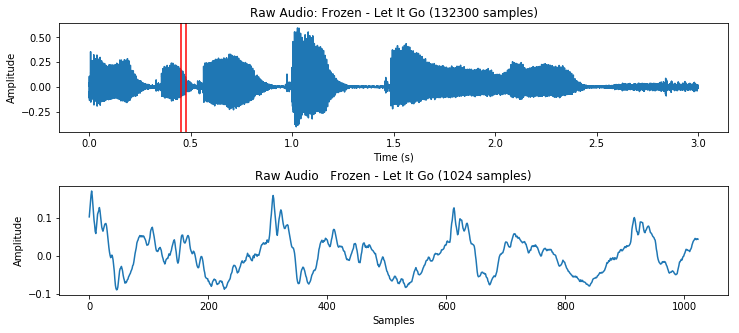

In [10]:
fig, ax = plt.subplots(2, figsize=(12,5))
fig.subplots_adjust(hspace=0.5)

# plot the entire clip
ax[0].plot(timesteps, clip)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Raw Audio: {} ({} samples)'.format(row.song_name, len(clip)))

n_fft = 1024 #frame length
start = 20000 #random initialisation
x = clip[start:start+n_fft]

# mark location of frame in the entire signal
ax[0].axvline(start/sample_rate, c='r')
ax[0].axvline((start+n_fft)/sample_rate, c='r')

# plot N samples
ax[1].plot(x)
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Raw Audio   {} ({} samples)'.format(row.song_name, len(x)))

In [16]:
Audio(clip, rate=sample_rate)

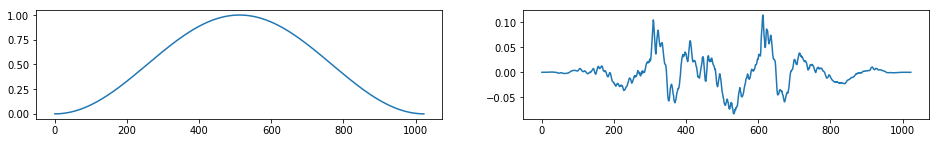

In [22]:
window = get_window('hann', n_fft)
wx = x * window

fig, ax = plt.subplots(1, 2, figsize=(16,2))
ax[0].plot(window)
ax[1].plot(wx)

In [23]:
# Compute (real) FFT on window
X = fft(x, n_fft)
X.shape, X.dtype

((1024,), dtype('complex64'))

((513,), dtype('float32'))

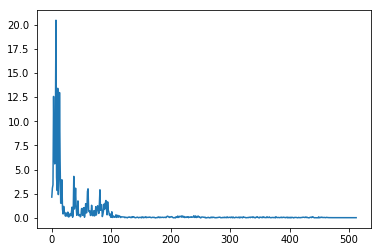

In [24]:
# Only use 1st half of output numbers, since 2nd half is redundant
X = X[:n_fft//2 + 1]

#Convert from rectangular coords to polar
X_magnitude, X_phase = librosa.magphase(X)

plt.plot(X_magnitude);

X_magnitude.shape, X_magnitude.dtype

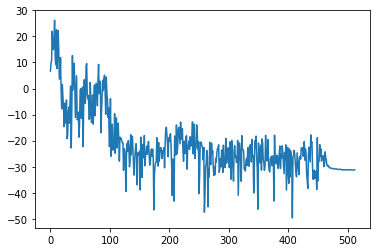

In [25]:
X_magnitude_db = librosa.amplitude_to_db(X_magnitude)
plt.plot(X_magnitude_db)

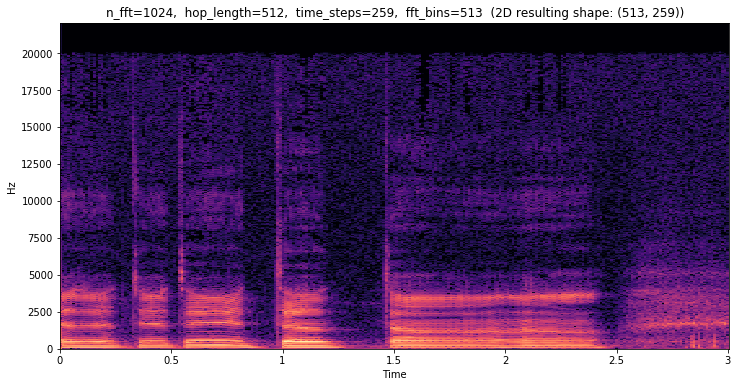

In [26]:
hop_length = 512
stft = librosa.stft(clip, n_fft=n_fft, hop_length=hop_length)
stft_magnitude, stft_phase = librosa.magphase(stft)
stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude, ref=np.max)

plt.figure(figsize=(12, 6))
librosa.display.specshow(stft_magnitude_db, x_axis='time', y_axis='linear', 
                         sr=sample_rate, hop_length=hop_length)

title = 'n_fft={},  hop_length={},  time_steps={},  fft_bins={}  (2D resulting shape: {})'
plt.title(title.format(n_fft, hop_length, 
                       stft_magnitude_db.shape[1], 
                       stft_magnitude_db.shape[0], 
                       stft_magnitude_db.shape));

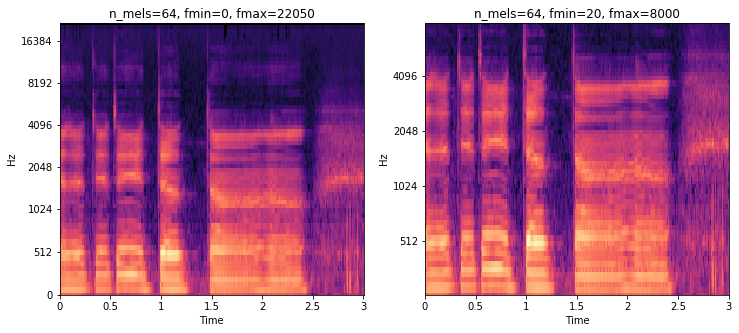

In [27]:
# number of mel frequency bands 
n_mels = 64

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

fmin = 0            
fmax = 22050 # sample_rate/2
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0,
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[0])
ax[0].set_title('n_mels=64, fmin=0, fmax=22050')

fmin = 20           
fmax = 8000
mel_spec = librosa.feature.melspectrogram(clip, n_fft=n_fft, hop_length=hop_length,
                                          n_mels=n_mels, sr=sample_rate, power=1.0, 
                                          fmin=fmin, fmax=fmax)
mel_spec_db = librosa.amplitude_to_db(mel_spec, ref=np.max)
librosa.display.specshow(mel_spec_db, x_axis='time',  y_axis='mel', 
                         sr=sample_rate, hop_length=hop_length, 
                         fmin=fmin, fmax=fmax, ax=ax[1])
ax[1].set_title('n_mels=64, fmin=20, fmax=8000')

plt.show()

## References
[1] Fast.ai experimental audio classification module: https://github.com/sevenfx/fastai_audio <br/>
[2] Article for fast.ai audio module: https://towardsdatascience.com/audio-classification-using-fastai-and-on-the-fly-frequency-transforms-4dbe1b540f89

In [ ]:
#Split the audio files (.wav) into 10s clips, stride=8
#num = 6
#for i in range(1,num):
#    create_audio_clips('Song' + str(i) + '/', 'Input_clips/', i)
#song_list = os.listdir('Input_clips/')
#label_dict = {}
#for i in range(len(song_list)):
#    label_dict['' + str(song_list[i])] = song_list[i][0] #label appears at the start of string
#    
#print(label_dict)